In [1]:
using Pkg
cmdir=joinpath(ENV["DATA"], "HD5t/precdr")
pdir =joinpath(ENV["PROJECTS"], "Petit")

Pkg.activate(pdir)
Pkg.instantiate()


  Activating project at `~/Projects/Petit`


In [2]:
using Petit
using Revise
using Plots
using DataFrames
using Statistics
using Images
using HDF5
using CSV
using Base: basename
using Printf
using ImageIO, Noise, ImageShow, ImageFiltering
using LaTeXStrings
using Images, TestImages, Deconvolution, Random
using FFTW

In [3]:
function ingredients(path::String)
    # this is from the Julia source code (evalfile in base/loading.jl)
    # but with the modification that it returns the module instead of the last object
    name = Symbol(basename(path))
    m = Module(name)
    Core.eval(m,
        Expr(:toplevel,
                :(eval(x) = $(Expr(:core, :eval))($name, x)),
                :(include(x) = $(Expr(:top, :include))($name, x)),
                :(include(mapexpr::Function, x) = $(Expr(:top, :include))(mapexpr, $name, x)),
                :(include($path))))
    m
end

ingredients (generic function with 1 method)

In [4]:
jn = ingredients(string(pdir,"/src/Petit.jl"))

Main.var"Petit.jl"

### Auxiliary functions

In [99]:
# Load auxiliary functions
include("itaca_aux.jl")
println("##Load auxiliary functions")

##Load auxiliary functions


### Diffusion coeficients

In [122]:
sigmat_xe = 3.5 # mm
sigmat_he = 1.5 # mm
sigmal_xe = 0.9 # mm
sigmal_he = 0.75 # mm
kB_ovr_e_lxe = 8.6173E-5 # V/K
kB_ovr_e_gxe = 2.59E-2 # V/K
sigmat_nh4_lxe_50 = sigma_t_ion_mm(170.0, 50.0, 400.0) # 50 cm drift, 400 V/cm
sigmat_nh4_lxe_10 = sigma_t_ion_mm(170.0, 10.0, 400.0) # 50 cm drift, 400 V/cm

sigmat_nh4_gxe_100 = sigma_t_ion_mm(298.0, 100.0, 400.0) # 100 cm drift, 400 V/cm
sigmat_nh4_gxe_50 = sigma_t_ion_mm(298.0, 50.0, 400.0) # 100 cm drift, 400 V/cm
sigmat_nh4_gxe_10 = sigma_t_ion_mm(298.0, 10.0, 400.0) # 100 cm drift, 400 V/cm

sigmat_e_xe_100 = sigma_t_mm(100.0, 10.0; dtmm=3.5)
sigmat_e_he_100 = sigma_t_mm(100.0, 10.0; dtmm=1.6)
sigmal_e_xe_100 = sigma_l_mm(100.0, 10.0; dlmm=0.9)
sigmal_e_he_100 = sigma_l_mm(100.0, 10.0; dlmm=0.75)

sigmat_e_xe_50 = sigma_t_mm(50.0, 10.0; dtmm=3.5)
sigmat_e_he_50 = sigma_t_mm(50.0, 10.0; dtmm=1.6)
sigmal_e_xe_50 = sigma_l_mm(50.0, 10.0; dlmm=0.9)
sigmal_e_he_50 = sigma_l_mm(50.0, 10.0; dlmm=0.75)

sigmat_e_xe_10 = sigma_t_mm(10.0, 10.0; dtmm=3.5)
sigmat_e_he_10 = sigma_t_mm(10.0, 10.0; dtmm=1.6)
sigmal_e_xe_10 = sigma_l_mm(10.0, 10.0; dlmm=0.9)
sigmal_e_he_10 = sigma_l_mm(10.0, 10.0; dlmm=0.75)

println("| Parameter                  | 100 mm          | 50 mm           | 10 mm           |")
println("|----------------------------|-----------------|-----------------|-----------------|")
println("| Ions (σₜ)                  | $(@sprintf("%.2f", sigmat_nh4_gxe_100)) mm | $(@sprintf("%.2f", sigmat_nh4_gxe_50)) mm | $(@sprintf("%.2f", sigmat_nh4_gxe_10)) mm |")
println("| Electrons in Xe (σₜ)       | $(@sprintf("%.2f", sigmat_e_xe_100)) mm | $(@sprintf("%.2f", sigmat_e_xe_50)) mm | $(@sprintf("%.2f", sigmat_e_xe_10)) mm |")
println("| Electrons in Xe/He (σₜ)    | $(@sprintf("%.2f", sigmat_e_he_100)) mm | $(@sprintf("%.2f", sigmat_e_he_50)) mm | $(@sprintf("%.2f", sigmat_e_he_10)) mm |")
println("| Electrons in Xe (σₗ)       | $(@sprintf("%.2f", sigmal_e_xe_100)) mm | $(@sprintf("%.2f", sigmal_e_xe_50)) mm | $(@sprintf("%.2f", sigmal_e_xe_10)) mm |")
println("| Electrons in Xe/He (σₗ)    | $(@sprintf("%.2f", sigmal_e_he_100)) mm | $(@sprintf("%.2f", sigmal_e_he_50)) mm | $(@sprintf("%.2f", sigmal_e_he_10)) mm |")

| Parameter                  | 100 mm          | 50 mm           | 10 mm           |
|----------------------------|-----------------|-----------------|-----------------|
| Ions (σₜ)                  | 1.13 mm | 0.80 mm | 0.36 mm |
| Electrons in Xe (σₜ)       | 11.07 mm | 7.83 mm | 3.50 mm |
| Electrons in Xe/He (σₜ)    | 5.06 mm | 3.58 mm | 1.60 mm |
| Electrons in Xe (σₗ)       | 2.85 mm | 2.01 mm | 0.90 mm |
| Electrons in Xe/He (σₗ)    | 2.37 mm | 1.68 mm | 0.75 mm |


### Load bb0nu dataframe

In [16]:
xfile = "/Users/jjgomezcadenas/Data/HD5t/lxe/0nubb_100um.next.h5"
filename = basename(xfile)
#hitdf = CSV.read(xfile, DataFrame)
dfs = get_dataset_dfs(xfile)
hitdf = dfs["hits"]
println("Loaded xfile = $(filename)")

Loaded xfile = 0nubb_100um.next.h5


### Analyze events

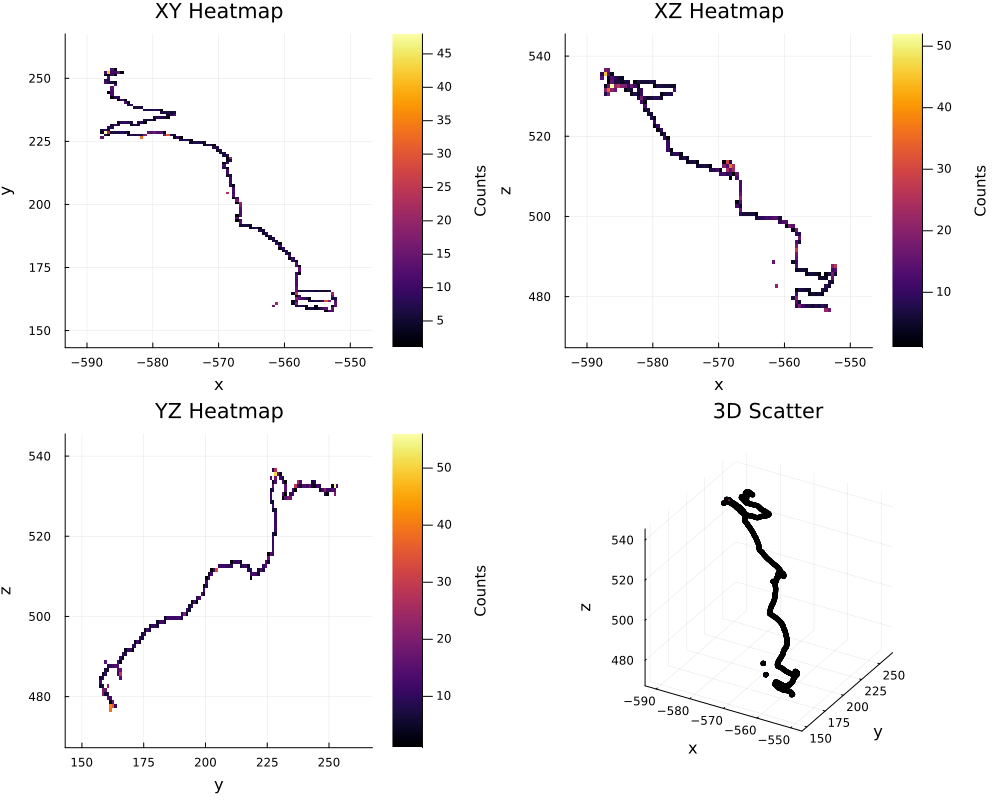

In [17]:
nevent =2
evtdf = get_event(hitdf, nevent)
evtdf.electrons = Int.(round.(evtdf.energy .* 1e5))
#plot_hits_projection(evtdf; projection="xy", nbins=100, background="white")
plot_hits_evt(hitdf, nevent; nbins=100)

In [39]:
#vevt = jn.Petit.voxelize_event(hitdf, nevent, 2.0)
#jn.Petit.plot_event(vevt; nbins=100)

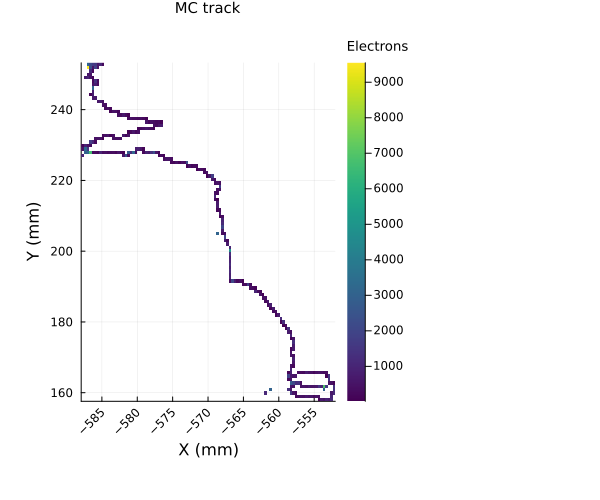

In [18]:
pxymc = plot_hits_projection(evtdf; projection="xy", nbins=100, title="MC track",
                              weight_column=:electrons, background="white",
                              aspect_ratio_limit=(0.5, 0.5),
                              colorbar_title_str="",
                              colorbar_title_location=:top,
                              colorbar_titlefontsize=9,
                              colorbar_tickfontsize=8,
                              right_margin_mm=50,
                              left_margin_mm=6,
                              bottom_margin_mm=6,
                              top_margin_mm=6)

xl = xlims(pxymc); yl = ylims(pxymc)
x_annot = xl[2] + 0.05*(xl[2]-xl[1])   # 5% beyond the right edge
y_annot = yl[2] + 0.05*(yl[2]-yl[1])  # 5% above top

# Now annotate 
annotate!(pxymc, (x_annot, y_annot, text("Electrons", 9, :black, :left)))

$\sigma$


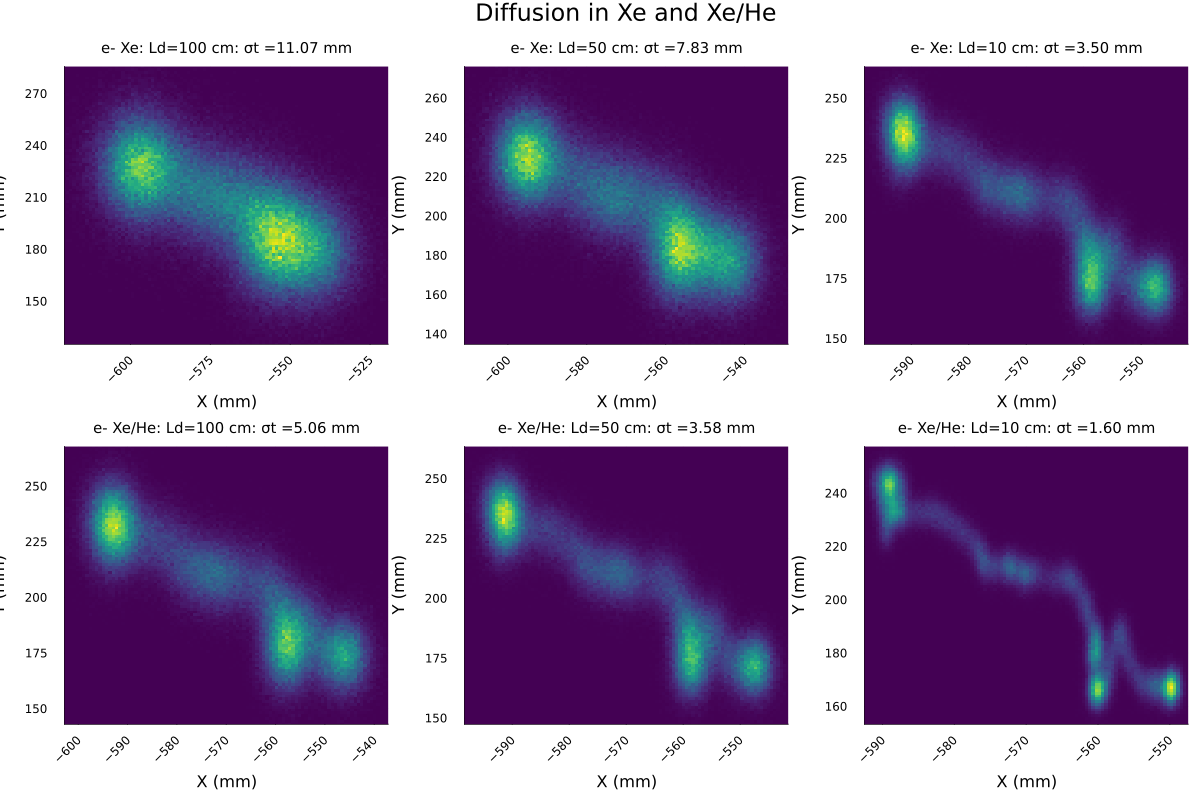

In [103]:
dxy_xe_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_100, nbins=100, nsigma=3.0)
pxe_100 = plot_diffused_xy(dxy_xe_100; title="""e- Xe: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_100)) mm""", colorbar=false)
dxy_xe_50 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_50, nbins=100, nsigma=3.0)
pxe_50 = plot_diffused_xy(dxy_xe_50; title="""e- Xe: Ld=50 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_50)) mm""", colorbar=false)
dxy_xe_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_xe_10, nbins=100, nsigma=3.0)
pxe_10 = plot_diffused_xy(dxy_xe_10; title="""e- Xe: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_e_xe_10)) mm""", colorbar=false)

dxy_he_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_100, nbins=100, nsigma=3.0)
pxe_100_he = plot_diffused_xy(dxy_he_100; title="""e- Xe/He: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_e_he_100)) mm""", colorbar=false)
dxy_he_50 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_50, nbins=100, nsigma=3.0)
pxe_50_he = plot_diffused_xy(dxy_he_50; title="""e- Xe/He: Ld=50 cm: σt =$(@sprintf("%.2f", sigmat_e_he_50)) mm""", colorbar=false)
dxy_he_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_e_he_10, nbins=100, nsigma=3.0)
pxe_10_he = plot_diffused_xy(dxy_he_10; title="""e- Xe/He: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_e_he_10)) mm""", colorbar=false)

dxy_nh4_100 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_nh4_gxe_100, nbins=100, nsigma=3.0)
pxe_100_nh4 =plot_diffused_xy(dxy_nh4_100; title="""Nh4: Ld=100 cm: σt =$(@sprintf("%.2f", sigmat_nh4_gxe_100)) mm""", colorbar=false)

dxy_nh4_10 =diffuse_xy_image_mc(evtdf; sigma_mm=sigmat_nh4_gxe_10, nbins=100, nsigma=3.0)
pxe_10_nh4 = plot_diffused_xy(dxy_nh4_10; title="""Nh4: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_nh4_gxe_10)) mm""", colorbar=false)

plot(pxe_100, pxe_50, pxe_10,pxe_100_he, pxe_50_he, pxe_10_he,
       layout=(2, 3),
       size=(1200, 800),
       plot_title="Diffusion in Xe and Xe/He",
       link=:both)  # Links axes if you want them synchronized

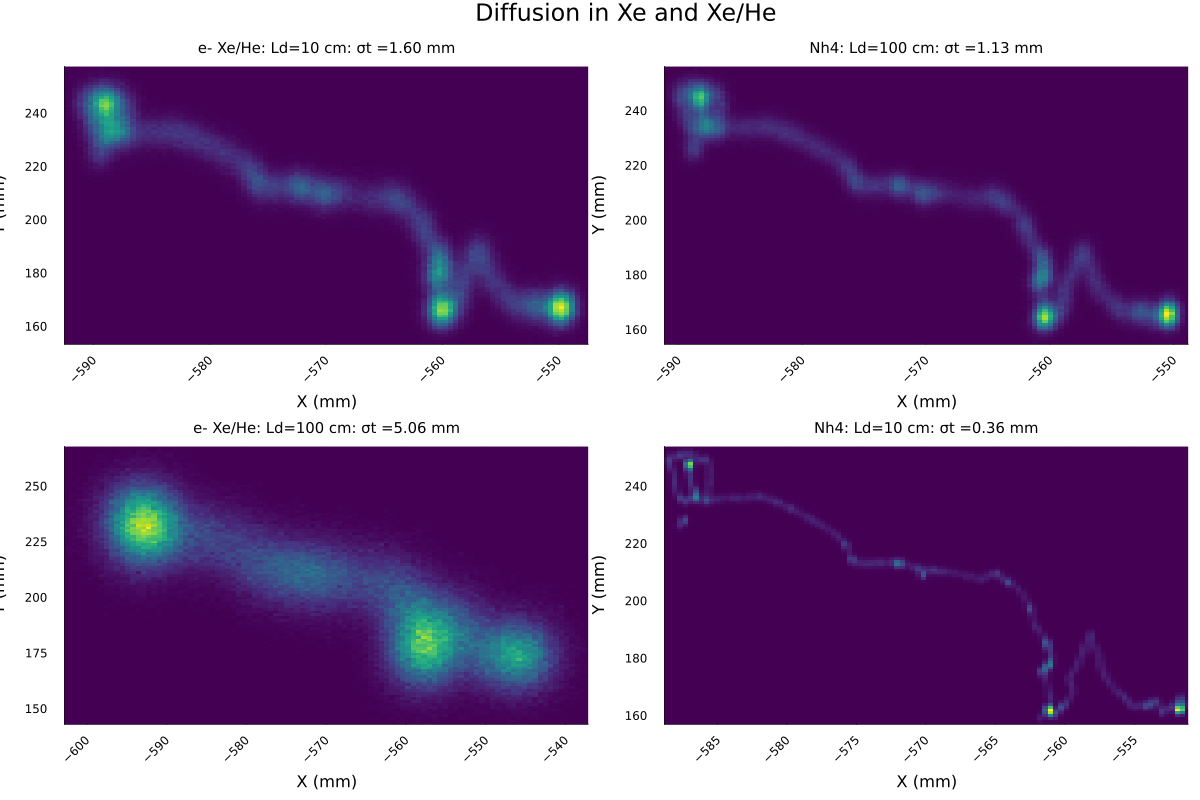

In [107]:
plot(pxe_10_he, pxe_100_nh4, pxe_100_he, pxe_10_nh4,
       layout=(2, 2),
       size=(1200, 800),
       plot_title="Diffusion in Xe and Xe/He",
       link=:both)

## LXe

In [113]:
xfile2 = "/Users/jjgomezcadenas/Data/HD5t/lxe/0nubb_50um_nest.csv"
filename2 = basename(xfile2)
hitlxe = CSV.read(xfile2, DataFrame)
println("Loaded xfile = $(filename2)")

Loaded xfile = 0nubb_50um_nest.csv


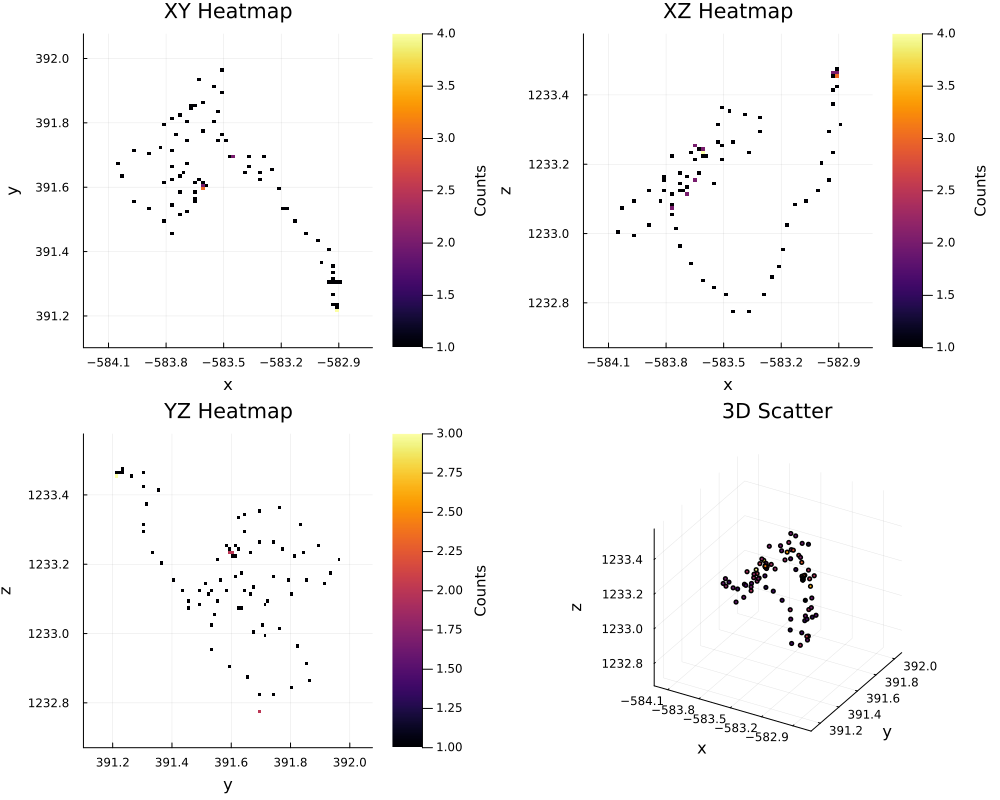

In [119]:
nevent2 =5
evtlxe = get_event(hitlxe, nevent2)
evtlxe.electrons = Int.(round.(evtlxe.energy .* 1e5))
#plot_hits_projection(evtdf; projection="xy", nbins=100, background="white")
plot_hits_evt(hitlxe, nevent2; nbins=100)

### Lxe plots

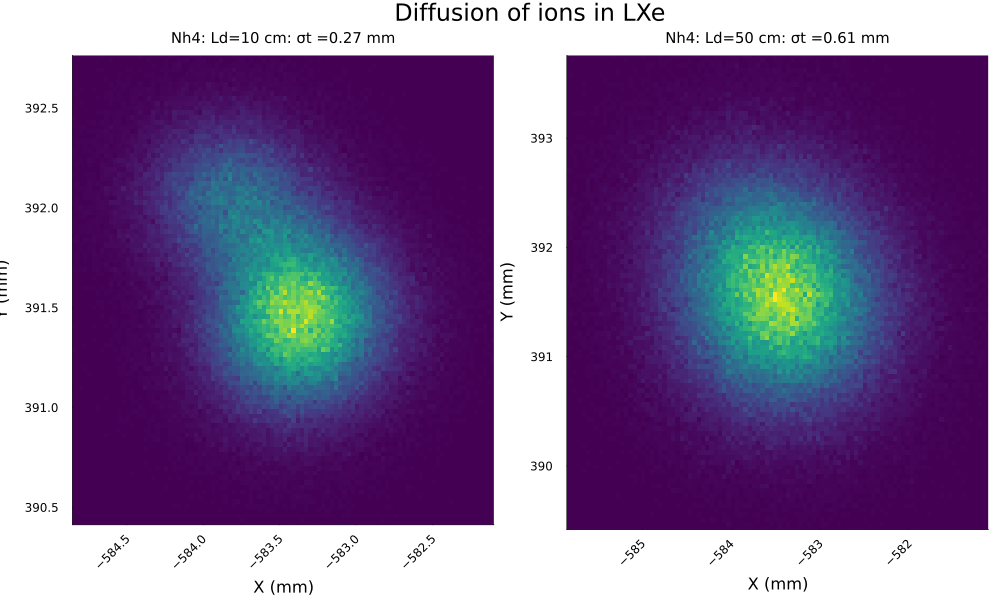

In [130]:
dxy_lxe_50 =diffuse_xy_image_mc(evtlxe; sigma_mm=sigmat_nh4_lxe_50, nbins=100, nsigma=3.0)
pxy_50_lxe = plot_diffused_xy(dxy_lxe_50; title="Nh4: Ld=50 cm: σt =$(@sprintf("%.2f", sigmat_nh4_lxe_50)) mm", colorbar=false)
dxy_lxe_10 =diffuse_xy_image_mc(evtlxe; sigma_mm=sigmat_nh4_lxe_10, nbins=100, nsigma=3.0)
pxy_10_lxe = plot_diffused_xy(dxy_lxe_10; title="Nh4: Ld=10 cm: σt =$(@sprintf("%.2f", sigmat_nh4_lxe_10)) mm", colorbar=false)
plot(pxy_10_lxe,pxy_50_lxe,
       layout=(1, 2),
    size=(1000, 600),
       plot_title="Diffusion of ions in LXe",
       link=:both)

### Make tracks

In [38]:
max_distance_mm = 10.0
energy_threshold_kev = 1.0
trks = make_tracks(evtdf, nevent;
				   max_dist=max_distance_mm,
				   energy_thr=energy_threshold_kev)
length(trks)

3

In [ ]:
0.6/4.0

In [ ]:
1.1/100.0

In [ ]:
dmc =diffuse_xy_image_mc(evtdf; sigma_mm=0.6, nbins=200, nsigma=3.0)
plot_diffused_xy(dmc; title="Event $nevent - Diffused XY")

In [ ]:
dmc =diffuse_xy_image_mc(evtdf; sigma_mm=0.6/2.3, nbins=200, nsigma=3.0)
plot_diffused_xy(dmc; title="Event $nevent - Diffused XY")

In [ ]:
dimg = diffuse_xy_image(evtdf; sigma_mm=0.6/2.3, nbins=100)
p = plot_diffused_xy(dimg; title="Event $nevent - Diffused XY")

In [ ]:
dimg2 = diffuse_xy_image_efficient(evtdf; sigma_mm=0.6, nbins=100)
p = plot_diffused_xy(dimg2; title="Event $nevent - Diffused XY (efficient)")